<a href="https://colab.research.google.com/github/sasaigoli05/BIOL105-CompBioModule/blob/main/HB_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 105 Computational Biology and Protein Engineering

You have been given a mutant Hemoglobin-B protein sequence that has mutations in its hydrophobic core region, 2.3-BPG binding sites, and iron binding sites. Your mission is to investigate these mutations and use your knowledge about protein structure to remedy the mutated hemoglobin to optimize its structural stability and oxygen binding affinity!

Temporary notes from Suhan:

- Core of HBB should be hydrophobic, in the mutant it is hydrophillic with positive and negative charges causing repulsive forces which would damage the stability of the structure
- 2,3-BPG is a large, negative molecule, so the binding sites should be positive to strongly bind 2,3-BPG. When they are changed to negative, the oxygen affinity goes up.
- The mutant has a very poor PLDDT score, which signifies the structure is not very stable. When the hydrophobic core is modified to have hydrophobic/neutral reisdues instead the stability and PLDDT goes up.

- Overall, each structure generation took around 10 minutes.


In [29]:
#@title STEP 0: Install Dependencies (Hit Play)
# Install ColabFold and dependencies
import os
import sys
from sys import version_info

python_version = f"{version_info.major}.{version_info.minor}"

# Check if AlphaFold and required packages are installed
if not os.path.isfile("COLABFOLD_READY"):
    print("Installing colabfold and dependencies...")
    os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
    if os.environ.get('TPU_NAME', False) != False:
        os.system("pip uninstall -y jax jaxlib")
        os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
    os.system("touch COLABFOLD_READY")

# Ensure ColabFold paths are correct
if f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

# Define the hydrophobic core based on the position of "GRLLVVYPWT" in the original hemoglobin sequence
hydrophobic_core_sequence = "GRLLVVYPWT"
original_sequence = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"

# Find positions of the hydrophobic core in the original sequence
core_start_index = original_sequence.find(hydrophobic_core_sequence) + 1
core_positions = list(range(core_start_index, core_start_index + len(hydrophobic_core_sequence)))

# Add "hydrophobic_core" to the residue_categories dictionary
residue_categories = {
    'BPG_binding': [2, 3, 83, 144],
    'iron_binding': [64, 93],
    'not_glycated': [60, 83, 96],
    'cleavage_sites': [8, 9, 26, 27, 30, 31, 36, 37, 38, 39, 46, 47, 53, 54, 57, 58, 60, 72, 73, 75, 76, 85, 86, 93, 94, 105, 106, 111, 112, 120, 121, 123, 124, 129, 130, 141, 142, 145, 146],
    'hydrophobic_core': core_positions  # Positions of the "hydrophobic core"
}

# Define dictionary for residue charges
residue_charge = {
    'K': 'positive',  # Lysine
    'R': 'positive',  # Arginine
    'H': 'positive',  # Histidine (partially positive at physiological pH)
    'D': 'negative',  # Aspartic acid
    'E': 'negative',  # Glutamic acid
    'A': 'neutral',  # Alanine
    'G': 'neutral',  # Glycine
    'V': 'neutral',  # Valine
    'L': 'neutral',  # Leucine
    'I': 'neutral',  # Isoleucine
    'P': 'neutral',  # Proline
    'F': 'neutral',  # Phenylalanine
    'M': 'neutral',  # Methionine
    'W': 'neutral',  # Tryptophan
    'S': 'neutral',  # Serine
    'T': 'neutral',  # Threonine
    'C': 'neutral',  # Cysteine (neutral, though can form disulfide bonds)
    'N': 'neutral',  # Asparagine
    'Q': 'neutral',  # Glutamine
    'Y': 'neutral'   # Tyrosine (polar, but neutral at physiological pH)
}

# Function to query residues based on category
def query_residues_by_category(sequence, category):
    """Query residues in sequence by category and determine charge type."""
    result = []
    for pos in residue_categories[category]:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based index
            charge = residue_charge.get(residue, 'unknown')
            result.append(f"Position {pos}: {residue} ({charge})")
    return result

# Updated function to print residues by category
def print_residues_by_category(category):
    """Prints residues and their charges based on the selected category."""
    residues_info = query_residues_by_category(mutant_sequence, category)
    print(f"Residues in the category '{category}':")
    for info in residues_info:
        print(info)
    if category == 'hydrophobic_core':
        print("\nCheck for hydrophilic or charged residues in the hydrophobic core!")
        hydrophilic_or_charged = [res for res in residues_info if 'positive' in res or 'negative' in res]
        if hydrophilic_or_charged:
            print("Warning: Hydrophilic or charged residues detected in the hydrophobic core:")
            for res in hydrophilic_or_charged:
                print(res)
            print("Consider changing these residues to hydrophobic (e.g., G, A, V, L, I, P, F, M, W) for stability.")

def calculate_binding_score(sequence):
    """
    Calculate a fictional binding score based on charge properties at specific positions.
    Higher score indicates better binding affinity to oxygen.
    """
    # Define target positions and their ideal charges for oxygen binding
    target_positions = [2, 3, 83, 144]
    score = 0

    # Scoring based on residue properties at specific positions
    for pos in target_positions:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based indexing
            if residue in ['D', 'E']:  # Negative charge - good for oxygen binding
                score += 30
            elif residue in ['A', 'G', 'V', 'L', 'I', 'P', 'F', 'M', 'W', 'S', 'T', 'N', 'Q', 'C', 'Y']:  # Neutral - moderate
                score += 15
            elif residue in ['K', 'R', 'H']:  # Positive charge - bad for oxygen binding
                score -= 10

    return score


# **STEP 1**
## Input the hemoglobin protein sequence, and identify the amino acids corresponding to the core of the protein (where O2 or 2,3-BPG will bind)

In [24]:
# This is the hemoglobin-b mutant sequence
mutant_sequence = "MKHLTPEEKSAVTALWGKVNVDEVGGEALKKKDDKQRFFESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"

2024-10-29 05:30:45,481 WARNING: no GPU detected, will be using CPU
2024-10-29 05:30:45,487 Found 2 citations for tools or databases
2024-10-29 05:30:45,488 Query 1/1: hemoglobin_mut (length 143)


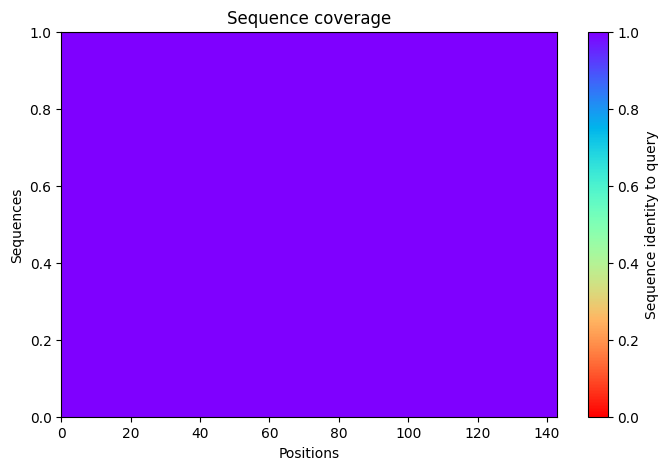

2024-10-29 05:34:08,659 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=41.1 pTM=0.336
2024-10-29 05:36:24,628 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=39.1 pTM=0.333 tol=5.83
2024-10-29 05:38:34,826 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=38.2 pTM=0.303 tol=5.66
2024-10-29 05:40:59,891 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=39.1 pTM=0.334 tol=5.06
2024-10-29 05:40:59,893 alphafold2_ptm_model_1_seed_000 took 589.5s (3 recycles)


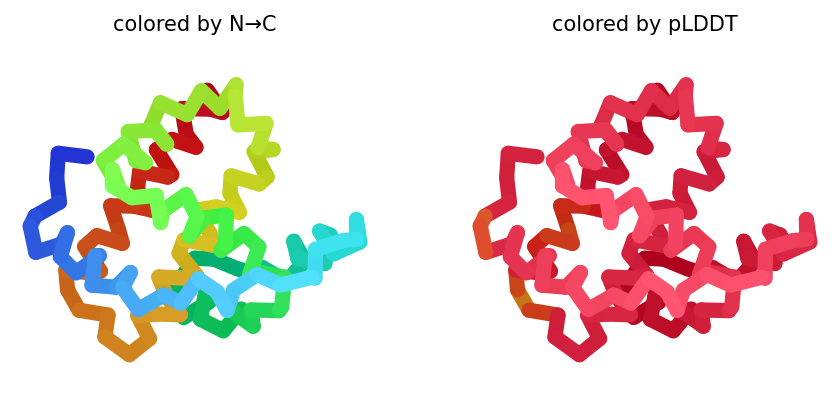

2024-10-29 05:41:00,155 reranking models by 'plddt' metric
2024-10-29 05:41:00,156 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=39.1 pTM=0.334
2024-10-29 05:41:00,865 Done
PDB file successfully generated: hemoglobin_mut/hemoglobin_mut_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

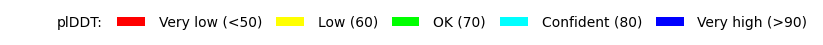

In [11]:
#@title Generate Mutant Hemoglobin Structure
# Import necessary libraries
import os
import sys
import warnings
from pathlib import Path
import numpy as np
import py3Dmol
import matplotlib.pyplot as plt
from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein, plot_plddt_legend
from colabfold.plot import plot_msa_v2
from Bio import BiopythonDeprecationWarning

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

# Check GPU type (optional)
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    if "1" in K80_chk:
        print("WARNING: Found GPU Tesla K80, limited to total length < 1000")
        if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
            del os.environ["TF_FORCE_UNIFIED_MEMORY"]
        if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
            del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]
except:
    pass

# Define the job parameters
jobname = "hemoglobin_mut"


# Create a directory for the job
os.makedirs(jobname, exist_ok=True)

# Save the sequence to a CSV file
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{mutant_sequence}")

# Define model and prediction parameters
model_type = "alphafold2_ptm"  # Adjusted to monomer model
msa_mode = "single_sequence"    # Single sequence MSA mode
pair_mode = "unpaired"          # Unpaired mode for monomer
is_complex = False              # Single sequence (not a complex)
display_images = True           # Display MSA and protein structures

# Set additional parameters
use_templates = False
custom_template_path = None
num_relax = 0
num_recycles = 3
relax_max_iterations = 0
recycle_early_stop_tolerance = 0
num_seeds = 1
use_dropout = False
dpi = 150
save_all = False
max_msa = None
save_recycles = False

# Set up logging
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

# Load queries and set model type based on complexity
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

# Download AlphaFold parameters if not present
download_alphafold_params(model_type, Path("."))

# Define input and prediction callback functions
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed and display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=dpi)
        plt.show()
        plt.close()

# Run AlphaFold prediction
try:
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=1,  # Use a single model for efficiency
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent="colabfold/google-colab-main",
    )
except Exception as e:
    print("Error during AlphaFold execution:", e)

# Check for generated PDB file
pdb_files = sorted(Path(jobname).glob("*.pdb"))
if not pdb_files:
    raise FileNotFoundError(f"No PDB files generated in: {jobname}")
else:
    pdb_file = pdb_files[0]
    print(f"PDB file successfully generated: {pdb_file}")

# Visualize the 3D structure with Py3Dmol
rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(pdb_file, 'r').read(), 'pdb')
view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
view.zoomTo()
view.show()

# Display the pLDDT score legend
plot_plddt_legend().show()


# **STEP 2**
## Print which of the core amino acids are positive vs negative

In [25]:
# This code is a function that looks for amino acid residues with specific functions, and prints it out for the user!
def print_residues_by_category(category):
    """Prints residues and their charges based on the selected category."""
    residues_info = query_residues_by_category(mutant_sequence, category)
    print(f"Residues in the category '{category}':")
    for info in residues_info:
        print(info)

# Call the function with the desired code ('BPG_binding', 'iron_binding', 'hydrophobic_core', 'not_glycated', 'cleavage_sites')


print_residues_by_category('BPG_binding') #THIS IS AN EXAMPLE, YOU SHOULD LOOK FOR THE RESIDUES WHICH ARE MUTATED
print_residues_by_category('iron_binding') #THIS IS AN EXAMPLE, YOU SHOULD LOOK FOR THE RESIDUES WHICH ARE MUTATED
print_residues_by_category('hydrophobic_core') #THIS IS AN EXAMPLE, YOU SHOULD LOOK FOR THE RESIDUES WHICH ARE MUTATED




Residues in the category 'BPG_binding':
Position 2: K (positive)
Position 3: H (positive)
Position 83: A (neutral)
Residues in the category 'iron_binding':
Position 64: V (neutral)
Position 93: L (neutral)
Residues in the category 'hydrophobic_core':
Position 30: K (positive)
Position 31: K (positive)
Position 32: K (positive)
Position 33: D (negative)
Position 34: D (negative)
Position 35: K (positive)
Position 36: Q (neutral)
Position 37: R (positive)
Position 38: F (neutral)
Position 39: F (neutral)


#**STEP 3**

In [27]:
#@title Predict Binding to Oxygen: use this field to modify the sequence to optimize the binding affinity to oxygen using what you know about amino acid properties { display-mode: "form"}
# Ask the student to input their modified sequence
modified_sequence = 'MDDLTPEEKSAVTALWGKVNVDEVGGEALVVVVVVVVVVESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH' #@param {type:"string"}

# Calculate the score for the modified sequence entered by the student
binding_score = calculate_binding_score(sequence)
print(f"Your new sequence has a binding score of {binding_score}.")
print("A higher score means better oxygen binding!")


Your new sequence has a binding score of 75.
A higher score means better oxygen binding!


2024-10-29 05:51:42,474 WARNING: no GPU detected, will be using CPU
2024-10-29 05:51:42,479 Found 2 citations for tools or databases
2024-10-29 05:51:42,480 Query 1/1: hemoglobin_mod (length 143)


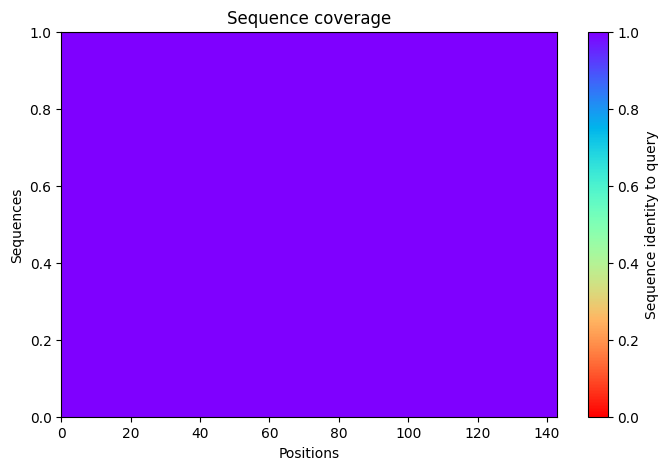

2024-10-29 05:54:38,367 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=38.8 pTM=0.288
2024-10-29 05:57:04,376 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=38.9 pTM=0.285 tol=5.43
2024-10-29 05:59:14,802 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=39.2 pTM=0.3 tol=5.3
2024-10-29 06:01:25,543 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=41 pTM=0.334 tol=3.05
2024-10-29 06:01:25,545 alphafold2_ptm_model_1_seed_000 took 566.1s (3 recycles)


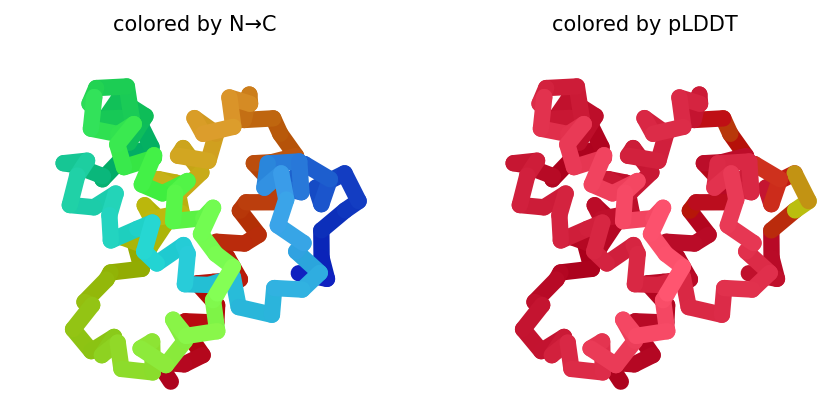

2024-10-29 06:01:25,927 reranking models by 'plddt' metric
2024-10-29 06:01:25,928 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=41 pTM=0.334
2024-10-29 06:01:26,598 Done
PDB file successfully generated: hemoglobin_mod/hemoglobin_mod_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

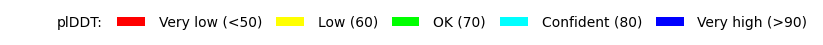

In [28]:
#@title Generate Remedied Hemoglobin Structure
# Import necessary libraries
import os
import sys
import warnings
from pathlib import Path
import numpy as np
import py3Dmol
import matplotlib.pyplot as plt
from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein, plot_plddt_legend
from colabfold.plot import plot_msa_v2
from Bio import BiopythonDeprecationWarning

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

# Check GPU type (optional)
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    if "1" in K80_chk:
        print("WARNING: Found GPU Tesla K80, limited to total length < 1000")
        if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
            del os.environ["TF_FORCE_UNIFIED_MEMORY"]
        if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
            del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]
except:
    pass

# Define the job parameters
jobname = "hemoglobin_mod"

complete_sequence = modified_sequence

# Create a directory for the job
os.makedirs(jobname, exist_ok=True)

# Save the sequence to a CSV file
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{complete_sequence}")

# Define model and prediction parameters
model_type = "alphafold2_ptm"  # Adjusted to monomer model
msa_mode = "single_sequence"    # Single sequence MSA mode
pair_mode = "unpaired"          # Unpaired mode for monomer
is_complex = False              # Single sequence (not a complex)
display_images = True           # Display MSA and protein structures

# Set additional parameters
use_templates = False
custom_template_path = None
num_relax = 0
num_recycles = 3
relax_max_iterations = 0
recycle_early_stop_tolerance = 0
num_seeds = 1
use_dropout = False
dpi = 150
save_all = False
max_msa = None
save_recycles = False

# Set up logging
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

# Load queries and set model type based on complexity
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

# Download AlphaFold parameters if not present
download_alphafold_params(model_type, Path("."))

# Define input and prediction callback functions
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed and display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=dpi)
        plt.show()
        plt.close()

# Run AlphaFold prediction
try:
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=1,  # Use a single model for efficiency
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent="colabfold/google-colab-main",
    )
except Exception as e:
    print("Error during AlphaFold execution:", e)

# Check for generated PDB file
pdb_files = sorted(Path(jobname).glob("*.pdb"))
if not pdb_files:
    raise FileNotFoundError(f"No PDB files generated in: {jobname}")
else:
    pdb_file = pdb_files[0]
    print(f"PDB file successfully generated: {pdb_file}")

# Visualize the 3D structure with Py3Dmol
rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(pdb_file, 'r').read(), 'pdb')
view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
view.zoomTo()
view.show()

# Display the pLDDT score legend
plot_plddt_legend().show()
